# **浮島発電所の発電量を予測してみる**

### **必要な関数・ライブラリ等の準備**

In [1]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

%matplotlib inline

import time

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [4]:
def normalize_array(x):
    '''
    min, max, min-max正規化を行なった配列(np.array)を返す
    '''
    x = np.array(x)
    x_min = x.min()
    x_max = x.max()
    normalized = (x - x_min) / (x_max - x_min) 
    return x_min, x_max, normalized

In [5]:
def denormalize_array(normalized_x, x_min, x_max):
    '''
    正規化前のmin, maxを用いて元のスケールに戻す
    '''
    normalized_x = np.array(normalized_x)
    denormalize_array = (normalized_x) * (x_max - x_min) + x_min
    return denormalize_array

In [6]:
def standardize_array(x):
    '''
    mean, sigma, 標準化された配列を返す
    '''
    x = np.array(x)
    x_mean = x.mean()
    x_sigma = x.std()
    standardized_array = (x - x_mean) / x_sigma
    return x_mean, x_sigma, standardized_array

In [7]:
def destandardize_array(standardized_x, x_mean, x_sigma):
    '''
    標準化前のmean, sigma用いて元のスケールに戻す
    '''
    standardized_x = np.array(standardized_x)
    destandardized_array = (standardized_x) * x_sigma + x_mean
    return destandardized_array

In [8]:
def get_chunked_data(x, chunk_size):
    '''
    rnnに突っ込むためのchunk_sizeごとに区切った系列データを作る
    '''
    input_list = []
    for i in range(0, len(x) - chunk_size + 1):
        input_list.append(x[i : i + chunk_size])
    input_list = np.array(input_list)
    return input_list

## **データの準備**

In [9]:
# データの読み込み
# 処理済みデータを読み込む。無かったら作る
try:
    output_data = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
    output_data['datetime'] = output_data['datetime'].map(lambda x : pd.to_datetime(x))
    
except:
    # train_kwhをエクセル等で開くとdatetimeが指数表示に直される可能性がある
    # その場合うまくいかないので201201010120の形になってることを確認する必要あり
    output_data = pd.read_csv('data/raw_data/train_kwh.tsv', delimiter = '\t')

    # datetimeの行をpd.Timestampのインスタンスに変更
    output_data = set_time(output_data, 'datetime')
    output_data['datetime'] = output_data['datetime'].map(lambda x : pd.to_datetime(x))

    # 30分ごとに合計を集計
    output_data = output_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

    output_data.to_csv('data/processed_data/out_put.tsv', sep='\t') 
    
output_data.head()

,datetime,SOLA01,SOLA02,SOLA03
0,2012-01-01 00:00:00,0,0.0,NaN
1,2012-01-01 00:30:00,0,0.0,NaN
2,2012-01-01 01:00:00,0,0.0,NaN
3,2012-01-01 01:30:00,0,0.0,NaN
4,2012-01-01 02:00:00,0,0.0,NaN


In [10]:
# データの読み込み
# 処理済みデータを読み込む。無かったら作る
try:
    amd_data = pd.read_csv('data/processed_data/amd_data.tsv', delimiter='\t')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))
    
except:
    # 河口湖アメダスのデータを使って予測する, amd_49251
    # 各amdidはamd_masterに記載されている
    amd_data = pd.read_csv('data/raw_data/amd_49251.tsv', delimiter = '\t')

    amd_data = set_time(amd_data, 'datetime')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))

    # 30分ごとに平均を集計
    amd_data = amd_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).mean()

    amd_data.to_csv('data/processed_data/amd_data.tsv', sep='\t')

amd_data.head()

,datetime,pr,f_pr,max_ws,f_max_ws,ave_wv,f_ave_wv,ave_ws,f_ave_ws,max_tp,f_max_tp,min_tp,f_min_tp,sl,f_sl,sd,f_sd,dsd,f_dsd
0,2012-01-01 00:00:00,0.0,0.0,22.333333,0.0,20.333333,0.0,10.000000,0.0,-15.666667,0.0,-26.333333,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,2012-01-01 00:30:00,0.0,0.0,15.333333,0.0,25.000000,0.0,9.333333,0.0,-34.666667,0.0,-40.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2,2012-01-01 01:00:00,0.0,0.0,20.000000,0.0,25.000000,0.0,10.666667,0.0,-35.333333,0.0,-43.666667,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3,2012-01-01 01:30:00,0.0,0.0,20.333333,0.0,21.666667,0.0,11.333333,0.0,-36.666667,0.0,-42.333333,0.0,0.0,2.0,0.0,0.0,0.0,0.0
4,2012-01-01 02:00:00,0.0,0.0,25.333333,0.0,21.000000,0.0,13.333333,0.0,-40.666667,0.0,-48.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0


In [11]:
# モデル構築のためにデータを分割する

# 日射量の欠損値を一つ前の値で置換/output_data
amd_data['sl'] = amd_data['sl'].fillna(method='bfill')

# 学習に必要なデータ
# 2012/01/01 00:00 ~ 2015/12/30 20:00のamdデータを用いて
# 2012/01/03 03:30 ~ 2015/12/31 23:30のデータを予測する
train_x_startID = amd_data[amd_data['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
train_x_endID = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-30 20:00')].index[0]
train_y_startID = amd_data[amd_data['datetime'] == pd.to_datetime('2012-01-03 03:30')].index[0]
train_y_endID = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]

train_amd_data = np.array(amd_data['sl'][train_x_startID:(train_x_endID+1)])
train_output_data = np.array(output_data['SOLA01'][train_y_startID:(train_y_endID+1)])

# 予測に必要なデータ
# 2015/12/29 20:30 ~ 2017/3/30 20:00のamdデータを用いて
# 2016/01/01 00:00 ~ 2017/3/31 23:30のoutputデータを予測する
test_startID = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-29 20:30')].index[0]
test_endID = amd_data[amd_data['datetime'] == pd.to_datetime('2017-3-30 20:00')].index[0]

test_amd_data = list(amd_data['sl'][test_startID:(test_endID+1)])

In [25]:
# rnnに突っ込むための準備

chunk_size = 49

# rnnに突っ込むために正規化しておく
amd_min, amd_max, normalized_amd = normalize_array(train_amd_data)
output_min, output_max, normalized_output = normalize_array(train_output_data)
test_amd_min, test_amd_max, normalized_test_amd = normalize_array(test_amd_data)

# rnnに突っ込むために標準化しておく
amd_mean, amd_sigma, standardized_amd = standardize_array(train_amd_data)
output_mean, output_sigma, standardize_output = standardize_array(train_output_data)
test_amd_mean, test_amd_sigma, standardize_test_amd = standardize_array(test_amd_data)

#時系列データのリストにする
input_list = get_chunked_data(normalized_amd, chunk_size)
test_input_list = get_chunked_data(normalized_test_amd, chunk_size)

# RNNに突っ込むためにデータを整形
X = np.array(input_list).reshape(len(input_list), chunk_size, 1)
Y = np.array(normalized_output).reshape(len(input_list), 1 )
X_predict = np.array(test_input_list).reshape(len(test_input_list), chunk_size, 1)

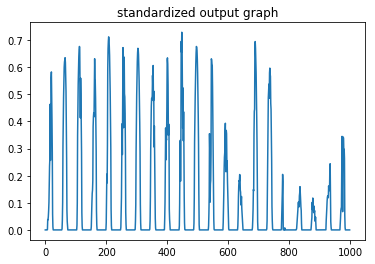

In [28]:
plt.plot(normalized_output[0:1000])
plt.title("output graph")

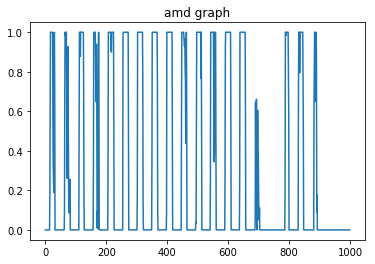

In [29]:
plt.plot(normalized_amd[0:1000])
plt.title("amd graph")

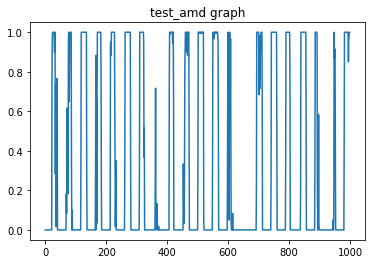

In [32]:
plt.plot(normalized_test_amd[0:1000])
plt.title("test_amd graph")

### **モデルの構築**

前日の20時までの山梨県富士河口湖のアメダスの日射量データを用いて翌日の00:00~23:30を予測する

前日の20時までのデータしか使えないので川崎近くのアメダスデータを使うのは予測として適切か疑問だったのでとりあえず1日程度ラグがありそうな(※要出典)ここのデータをつかう

(例)

8/17の00:00 ~ 23:30を予測するとき

8/17の23:30を8/15 20:00 ~ 8/16 20:00

8/17の23:00を8/15 19:30 ~ 8/16 19:30

....

8/17の00:00を8/14 20:30 ~ 8/15 20:30で予測する

参考サイト：http://www.madopro.net/entry/char_level_lm_with_simple_rnn

　　　　　　https://qiita.com/yukiB/items/f6314d2861fc8d9b739f

          https://www.tensorflow.org/install/migration
          

In [33]:
class simpleLSTM:
    def __init__(self, X, Y):
        '''
        諸変数の設定
        '''
        self.input_layer_size = 1 #入力層の数、一つ一つのデータはslの値ひとつだけなので1
        self.hidden_layer_size = 100 # 隠れ層の数、適当
        self.output_layer_size = 1 #出力層の数、求める値は時間あたりの発電量の値1つなので1
        self.batch_size = 200 #バッチサイズ、適当
        self.chunk_size = 49 # 一回の系列データの長さ
        self.learning_rate = 0.01 # 学習率 適当
        self.forget_bias = 0.9  # 忘却率
        self.epochs = 100 #エポック数
        
        # 学習データと検証用データに分けておく
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.1)))
        self.X = X # 入力
        self.Y = Y # 教師
        self.X_val = X_val # 検証用
        self.Y_val = Y_val #検証用
        
    def shuffle(self):
        '''
        ミニバッチかする際にランダムにシャッフル
        '''
        idx = [i for i in range(self.X.shape[0])]
        np.random.shuffle(idx)
        xs = np.array([[y for y in list(self.X[r])] for r in idx])
        ys = np.array([self.Y[r] for r in idx])
        return xs, ys
        
    def inference(self, input_ph, inistate_ph):
        '''
        グラフの構築
        '''
        
        # 重みとバイアスの初期化
        hidden_w = tf.Variable(tf.truncated_normal([self.input_layer_size, self.hidden_layer_size], stddev=0.01), name='hidden_w')
        hidden_b = tf.Variable(tf.truncated_normal([self.hidden_layer_size]), name='hidden_b')
        output_w = tf.Variable(tf.truncated_normal([self.hidden_layer_size, self.output_layer_size], stddev=0.01), name='output_w')
        output_b = tf.Variable(tf.truncated_normal([self.output_layer_size]), name='output_b')
        
        #　input_phの整型  
        in1 = tf.transpose(input_ph, [1, 0, 2]) 
        in2 = tf.reshape(in1, [-1, self.input_layer_size]) 
        in3 = tf.matmul(in2, hidden_w) + hidden_b
        in4 = tf.split(in3, self.chunk_size, 0)
          
            
        # BasicLSTMCellを定義
        cell = tf.contrib.rnn.BasicLSTMCell(self.hidden_layer_size, forget_bias=self.forget_bias, state_is_tuple=False)
        rnn_outputs, states = tf.contrib.rnn.static_rnn(cell, in4, initial_state=inistate_ph)
        output = tf.matmul(rnn_outputs[-1], output_w) + output_b
        results = [hidden_w, output_w, hidden_w, hidden_b]
        return output, states, results
        
    def loss(self, output_ph, actual_ph):
        '''
        お題と同じmean absolute errorを仕様
        '''
        cost = tf.reduce_mean(tf.abs(output_ph - actual_ph))
        tf.summary.scalar('loss', cost)
        return cost
    
    def training(self, cost):
        '''
        adamを仕様beta1, beta2は元論文の推奨値を仕様
        '''
        with tf.name_scope("training") as scope:
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.9, beta2=0.999).minimize(cost)
            return optimizer
    
    def train(self):
        '''
        学習
        '''
        random.seed(0)
        np.random.seed(0)
        tf.set_random_seed(0)
        n_batch = self.X.shape[0] // self.batch_size
        
        with tf.Graph().as_default():
            # 変数の用意
            input_ph = tf.placeholder('float', [None, self.chunk_size, self.input_layer_size], name='input')
            actual_ph = tf.placeholder('float', [None, self.output_layer_size], name='actual_value')
            inistate_ph = tf.placeholder('float', [None, self.hidden_layer_size * 2], name='inistate')

            prediction, state, weights = self.inference(input_ph, inistate_ph)
            cost = self.loss(prediction, actual_ph)
            optimizer = self.training(cost)

            # TensorBoardで可視化する
            summary = tf.summary.merge_all()
            # 初期化
            init = tf.global_variables_initializer()
                
            # ここから学習
            with tf.Session() as sess:
                # 学習したモデルも保存しておく
                saver = tf.train.Saver()
                summary_writer = tf.summary.FileWriter("/tmp/tensorflow_log", graph=sess.graph)
                sess.run(init)

                for epoch in range(self.epochs):
                    X_, Y_ = self.shuffle()
                    for i in range(n_batch):
                        start = i * self.batch_size
                        end = start + self.batch_size
                        inputs  = X_[start:end]
                        actuals = Y_[start:end]
                        train_dict = {
                            input_ph:      inputs,
                            actual_ph:     actuals,
                            inistate_ph:     np.zeros((self.batch_size, self.hidden_layer_size * 2)),
                        }
                    
                    sess.run(optimizer, feed_dict=train_dict)

                    if (epoch) % 10 == 0:
                        val_dict = {
                            input_ph:      self.X_val,
                            actual_ph:     self.Y_val,
                            inistate_ph:     np.zeros((self.X_val.shape[0], self.hidden_layer_size * 2)),
                        }
                        summary_str, train_loss = sess.run([summary, cost], feed_dict=val_dict)
                        print("train#%d, validation loss: %e" % (epoch, train_loss))
                        summary_writer.add_summary(summary_str, epoch)
                        
                datas = sess.run(weights)
                saver.save(sess, "./data/model/wiki2.ckpt")
                
    def predict(self, X_predict):
        '''
        予測期間に該当するデータから予測
        '''
        # 予測に使う変数の用意
        tf.reset_default_graph()
        input_ph = tf.placeholder("float", [None, self.chunk_size, self.input_layer_size], name='input')
        inistate_ph = tf.placeholder("float", [None, self.hidden_layer_size * 2], name='inistate')
        prediction, state, weights = self.inference(input_ph, inistate_ph)
        pre_dict = {
            input_ph: X_predict,
            inistate_ph: np.zeros((X_predict.shape[0], self.hidden_layer_size*2))
        }
        
        # 初期化
        init = tf.global_variables_initializer()

        with tf.Session() as sess:
            # 保存したモデルをロード
            saver = tf.train.Saver()
            saver.restore(sess, "./data/model/wiki2.ckpt")

            # ロードしたモデルを使って予測結果を計算
            expected_output = sess.run([prediction], feed_dict=pre_dict)


        return expected_output

In [34]:
model_01 = simpleLSTM(X, Y)

In [35]:
model_01.train()

train#0, validation loss: 4.904627e-01
train#10, validation loss: 2.037144e-01
train#20, validation loss: 2.356225e-01
train#30, validation loss: 1.674369e-01
train#40, validation loss: 1.635202e-01
train#50, validation loss: 1.698203e-01
train#60, validation loss: 1.577090e-01
train#70, validation loss: 1.543608e-01
train#80, validation loss: 1.942676e-01
train#90, validation loss: 1.813208e-01


In [50]:
predict = model_01.predict(X)
predict = np.array(predict).reshape(len(predict[0]))
processed_predict = denormalize_array(predict, output_min, output_max)

INFO:tensorflow:Restoring parameters from ./data/model/wiki2.ckpt


In [51]:
# 2016/01/01 00:00 ~ 2017/3/31 23:30の予測データを書き出す
s_idx = amd_data[amd_data['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
e_idx = amd_data[amd_data['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
predict_data = pd.DataFrame({"datetime":amd_data['datetime'][s_idx:e_idx+1], "expected_output":processed_predict})
predict_data.index = np.arange(len(predict_data))
predict_data.to_csv('data/predicted_data/predict_SOLA01.tsv', sep = '\t')

ValueError: array length 70025 does not match index length 21888

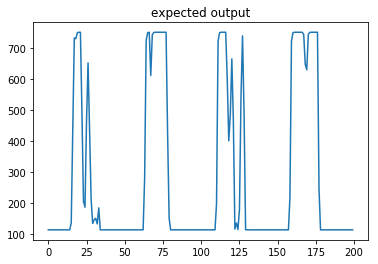

In [52]:
plt.plot(processed_predict[0:200])
plt.title("expected output")

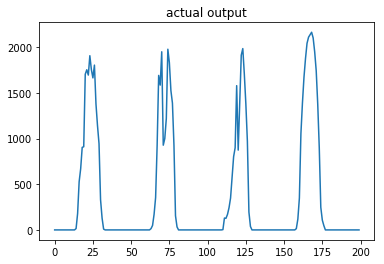

In [49]:
plt.plot(output_data['SOLA01'][0:200])
plt.title("actual output")

In [53]:
amd_data['sl']

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
5          0.000000
6          0.000000
7          0.000000
8          0.000000
9          0.000000
10         0.000000
11         0.000000
12         0.000000
13         0.000000
14         0.000000
15       113.333333
16       403.333333
17       600.000000
18       600.000000
19       600.000000
20       600.000000
21       600.000000
22       600.000000
23       600.000000
24       600.000000
25       350.000000
26       196.666667
27       150.000000
28       113.333333
29       586.666667
            ...    
91986      0.000000
91987      0.000000
91988      0.000000
91989      0.000000
91990      0.000000
91991      0.000000
91992      0.000000
91993      0.000000
91994      0.000000
91995      0.000000
91996      0.000000
91997      0.000000
91998      0.000000
91999      0.000000
92000      0.000000
92001      0.000000
92002      0.000000
92003      0.000000
92004      0.000000


### ** 新モデルの構築 **

前日の20時までの山梨県富士河口湖のアメダスの日射量データを用いて翌日の00:00~23:30を予測する

一個上のモデルでは発電量が0の時とそうでない時とで差が大きすぎたので予測値が不適切になりがち

予測に使う変数は上記モデルとおなじままにLSTMの出力を[0フラグ, 発電量の予測]にしてみたい

LOSSは0フラグのエントロピーと0でない時の発電量の予測値と実測値の合算にする

(例)

[1, 0.0432] 0フラグがあるので発電量としては0, 計算値は0.0432

[0, 0.497] 0フラグがないので発電量は計算値そのままをつかい0.497 (あとでスケールを戻す)

### **新モデルのためのデータ再構築**

In [26]:
# モデル構築のためにデータを分割する

# 日射量の欠損値を一つ前の値で置換/output_data
amd_data['sl'] = amd_data['sl'].fillna(method='bfill')

# 学習に必要なデータ
# 2012/01/01 00:00 ~ 2015/12/30 20:00のamdデータを用いて
# 2012/01/03 03:30 ~ 2015/12/31 23:30のデータを予測する
train_x_startID = amd_data[amd_data['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
train_x_endID = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-30 20:00')].index[0]
train_y_startID = amd_data[amd_data['datetime'] == pd.to_datetime('2012-01-03 03:30')].index[0]
train_y_endID = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]

train_amd_data = np.array(amd_data['sl'][train_x_startID:(train_x_endID+1)])
train_output_data = np.array(output_data['SOLA01'][train_y_startID:(train_y_endID+1)])

# 予測に必要なデータ
# 2015/12/29 20:30 ~ 2017/3/30 20:00のamdデータを用いて
# 2016/01/01 00:00 ~ 2017/3/31 23:30のoutputデータを予測する
test_startID = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-29 20:30')].index[0]
test_endID = amd_data[amd_data['datetime'] == pd.to_datetime('2017-3-30 20:00')].index[0]

test_amd_data = list(amd_data['sl'][test_startID:(test_endID+1)])

In [ ]:
def add_lable_data(x, threshold):
    '''
    発電量が閾値以下なら1を、以上なら0のラベルをつけながら標準化
    '''
    droped_output_data = x[np.where(x>100)]
    
    for 

In [27]:
# rnnに突っ込むための準備

chunk_size = 49

# rnnに突っ込むために正規化しておく
amd_min, amd_max, normalized_amd = normalize_array(train_amd_data)
output_min, output_max, normalized_output = normalize_array(train_output_data)
test_amd_min, test_amd_max, normalized_test_amd = normalize_array(test_amd_data)

# rnnに突っ込むために標準化しておく
amd_mean, amd_sigma, standardized_amd = standardize_array(train_amd_data)
output_mean, output_sigma, standardize_output = standardize_array(train_output_data)
test_amd_mean, test_amd_sigma, standardize_test_amd = standardize_array(test_amd_data)

#時系列データのリストにする
input_list = get_chunked_data(standardized_amd, chunk_size)
test_input_list = get_chunked_data(standardize_test_amd, chunk_size)

# RNNに突っ込むためにデータを整形
X = np.array(input_list).reshape(len(input_list), chunk_size, 1)
Y = np.array(normalized_output).reshape(len(input_list), 1 )
X_predict = np.array(test_input_list).reshape(len(test_input_list), chunk_size, 1)

(array([ 6738.,  4164.,  2994.,  2660.,  2596.,  2695.,  3273.,  2749.,
         1531.,   240.]),
 array([  101. ,   431.8,   762.6,  1093.4,  1424.2,  1755. ,  2085.8,
         2416.6,  2747.4,  3078.2,  3409. ]),
 <a list of 10 Patch objects>)

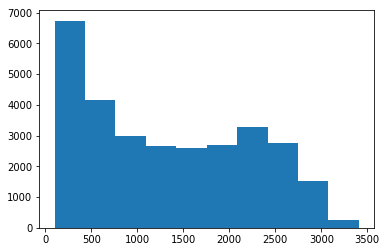

In [25]:
plt.hist(output_data[output_data['SOLA01'] > 100]['SOLA01'])

In [32]:
x = train_output_data[np.where(train_output_data>100)]

In [34]:
x_mean = x.mean()
x_sigma = x.std()
print(x_mean, x_sigma)

1320.3721967 893.327325998


In [35]:
x_ = train_output_data
x__mean = x_.mean()
x__sigma = x_.std()
print(x__mean, x__sigma)

560.432445555 872.133458786
